In [1]:
import numpy as np
import pytreenet as ptn
from copy import deepcopy
np.random.seed(67)

In [2]:
d = 3

In [3]:
def save_list(list_to_save, filename):
    filename = f"results/{filename}"
    with open(filename, 'w') as file:
        for item in list_to_save:
            file.write(str(item) + '\n')
    print(f"List saved to {filename}")

def load_list(filename):
    filename = f"results/{filename}"
    try:
        with open(filename, 'r') as file:
            return [complex(line.strip()) for line in file.readlines()]
    except FileNotFoundError:
        print(f"File {filename} not found.")
        return []

In [4]:
def product_state(ttn, bond_dim=2 , physical_dim= 2):
    product_state = deepcopy(ttn)
    A = np.asarray(d*[1j/np.sqrt(physical_dim)])
    for node_id in product_state.nodes.keys():
        n = product_state.tensors[node_id].ndim - 1
        tensor = A.reshape((1,) * n + (physical_dim,))
        T = np.pad(tensor, n*((0, bond_dim-1),) + ((0, 0),))
        product_state.tensors[node_id] = T
        product_state.nodes[node_id].link_tensor(T)  
    return product_state

In [5]:
shapes = {
    (0, 0): (2, 2, 2, d),
    (0, 1): (2, 2, d),
    (0, 2): (2, 2, d),
    (1, 0): (2, 2, d),
    (1, 1): (2, d),
    (1, 2): (2, d),
    (2, 0): (2, 2, d),
    (2, 1): (2, 2, 2, d),
    (2, 2): (2, d)
}


sites = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(3) for j in range(3)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(sites[(0, 0)][0], sites[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 1, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 1, 0),
    ((2, 1), (1, 1), 1, 0),
    ((2, 1), (2, 2), 2, 0)]


for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(sites[child][0], sites[child][1], child_leg, parent_id, parent_leg)

# ttn = product_state(ttn , bond_dim= 2, physical_dim = d)

nodes = {
    (i, j): (ptn.Node(tensor=ttn.tensors[f"Site({i},{j})"].conj() , identifier=f"Node({i},{j})"), ttn.tensors[f"Site({i},{j})"].conj()) for i in range(3) for j in range(3)
}

ttn.add_child_to_parent(nodes[(0,0)][0], nodes[(0,0)][1], 2, "Site(0,0)", 2)

connections = [
    ((0, 0), (0, 1), 1, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 2, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 1, 0),
    ((2, 1), (1, 1), 1, 0),
    ((2, 1), (2, 2), 2, 0),
]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Node({parent[0]},{parent[1]})"
    child_id = f"Node({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)

In [6]:
I = ptn.TTNO.Identity(ttn)
ptn.adjust_bra_to_ket(ttn)

for ket_id in list(ttn.nodes.keys())[0:len(ttn.nodes)//2]:
    i, j = ket_id.replace('Site(', '').replace(')', '').split(',')
    bra_id = f"Node({i},{j})"
    assert np.array_equal(ttn.tensors[ket_id].conj(), ttn.tensors[bra_id])

# ttn = ptn.normalize_ttn_Lindblad(ttn)

ttn.operator_expectation_value_Lindblad(I)


array(2254860.13863589+5.82076609e-11j)

In [7]:
def Liouville(t, U, J, m, L, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)


    }
    
    conversion_dict.update({
        "it * b^dagger": t*1j * creation_op,
        "it * b": t*1j * annihilation_op,
        "-iU * n * (n - 1)": -U*1j * number_op @ (number_op - np.eye(d)),
        "m*n": m*number_op
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-iU * n * (n - 1)"}))

    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "m*n"}))        
    
    H1 = ptn.Hamiltonian(terms, conversion_dict)
    
    conversion_dict = {
        "b^dagger.T": creation_op.T,
        "b.T": annihilation_op.T,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-it * b^dagger.T": -t*1j * creation_op.T,
        "-it * b.T": -t*1j * annihilation_op.T,
        "iU * n * (n - 1).T": (U*1j * number_op @ (number_op - np.eye(d))).T,
        "-m*n.T": -m * number_op.T

    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Node({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", right_neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", right_neighbor: "b^dagger.T"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Node({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", up_neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", up_neighbor: "b^dagger.T"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "iU * n * (n - 1).T"}))    

    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-m*n.T"}))
            
    H2 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H2)

    
    J = np.sqrt(J)
    conversion_dict = {    
    "L": J*L,
    "L^dagger.T": J*L.conj(),
    "-1/2 (L^dagger @ L) ": -1/2 * J *  L.conj().T @ L,
    "-1/2 (L^dagger @ L).T":-1/2 * J * (L.conj().T @ L).T}

    terms = []
    for x in range(Lx):
        for y in range(Ly):
            out_site = f"Node({x},{y})"
            in_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({in_site: "L"}))
            terms.append(ptn.TensorProduct({out_site: "L^dagger.T"}))
            terms.append(ptn.TensorProduct({in_site: "-1/2 (L^dagger @ L) "}))
            terms.append(ptn.TensorProduct({out_site: "-1/2 (L^dagger @ L).T"}))

    H3 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H3)
    return H1

In [8]:
def Unitary(t, U, m, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "it * b^dagger": t * 1.0j* creation_op,
        "it * b": t* 1.0j * annihilation_op,
        "-iU * n * (n - 1)": -U* 1.0j * number_op @ (number_op - np.eye(d)),
        "m*n": m * number_op

    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-iU * n * (n - 1)"}))
    
    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "m*n"}))

    H1 = ptn.Hamiltonian(terms, conversion_dict)
    
    conversion_dict = {
        "b^dagger.T": creation_op.T,
        "b.T": annihilation_op.T,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-it * b^dagger.T": -t* 1.0j * creation_op.T,
        "-it * b.T": -t* 1.0j * annihilation_op.T,
        "iU * n * (n - 1).T": (U* 1.0j* number_op @ (number_op - np.eye(d))).T,
        "-m*n.T": -m * number_op.T
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Node({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", right_neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", right_neighbor: "b^dagger.T"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Node({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", up_neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", up_neighbor: "b^dagger.T"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "iU * n * (n - 1).T"}))   

    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-m*n.T"}))         

    H2 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H2)
    return H1

In [9]:
def BoseHubbard_ham(t, U, m, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)}
    
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op,
        "-t * b": -t * annihilation_op,
        "U * n * (n - 1)": U * number_op @ (number_op - np.eye(d)),
        "-m*n": -m * number_op
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "U * n * (n - 1)"}))
    
    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-m*n"}))

    return ptn.Hamiltonian(terms, conversion_dict)

def BoseHubbard_ham_tp(t, U, Lx, Ly):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op,
        "-t * b": -t * annihilation_op,
        "U * n * (n - 1)": U * number_op @ (number_op - np.eye(d))
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site:  -t * creation_op, right_neighbor: annihilation_op}))
                terms.append(ptn.TensorProduct({current_site: -t * annihilation_op, right_neighbor: creation_op}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site:  -t * creation_op, up_neighbor: annihilation_op}))
                terms.append(ptn.TensorProduct({current_site: -t * annihilation_op, up_neighbor: creation_op}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: U * number_op @ (number_op - np.eye(d))}))
    
    return terms

In [10]:
def Number_op_total(Lx, Ly, dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {"n": number_op , f"I{dim}": np.eye(dim)}

    terms = []
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "n"}))

    return ptn.Hamiltonian(terms, conversion_dict)     

def Number_op_local( node_id , dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {"n": number_op , f"I{dim}": np.eye(dim)}

    terms = []
    terms.append(ptn.TensorProduct({node_id: "n"}))

    return ptn.Hamiltonian(terms, conversion_dict)

def Correlation_function(node_id1, node_id2, dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{dim}": np.eye(dim)
    }
    
    terms = []
    terms.append(ptn.TensorProduct({node_id1: "b^dagger", node_id2: "b"}))
    return ptn.Hamiltonian(terms, conversion_dict)

In [11]:
def exchange_bra_ket_tensors(ttn):
    state = deepcopy(ttn)
    ptn.adjust_bra_to_ket(state)
    for ket_id in list(state.nodes.keys())[:(len(state.nodes.keys())//2)]:
        i, j = ket_id.replace('Site(', '').replace(')', '').split(',')
        bra_id = f"Node({i},{j})"
        T1 = state.tensors[bra_id]
        T2 = state.tensors[ket_id]
        state.tensors[ket_id] = T1
        state.nodes[ket_id].link_tensor(T1)
        state.tensors[bra_id] = T2
        state.nodes[bra_id].link_tensor(T2)
    return state

def substitute_out_or_in_legs_of_ttn_with_identity(state, out_or_in , bond_dim=2):
    ttn = deepcopy(state)
    if out_or_in == "Out":
       for node_id in list(ttn.nodes.keys())[(len(ttn.nodes.keys())//2):]:
        n = ttn.tensors[node_id].ndim - 1
        T = np.reshape(np.array([[1,0]]), (n*(1,) + (2,)))
        T = np.pad(T, n*((0, bond_dim-1),) + ((0, 0),))
        ttn.tensors[node_id] = T
        ttn.nodes[node_id].link_tensor(T)   
    if out_or_in == "In":
        for node_id in list(ttn.nodes.keys())[:len(ttn.nodes.keys())//2]:
            n = ttn.tensors[node_id].ndim
            T = ttn.tensors[node_id]
            T = np.reshape(np.array([[1,0]]), (n*(1,) + (2,)))
            T = np.pad(T, n*((0, bond_dim-1),) + ((0, 0),))
            ttn.tensors[node_id] = T
            ttn.nodes[node_id].link_tensor(T)        
    return ttn


In [12]:
t = 0.1
U = 0.1
m = 0.1

# TTNO : Hamiltonian acting on in_legs
H1 = BoseHubbard_ham(t, U, m, 3, 3, d)
H1 = H1.pad_with_identities(ttn, symbolic= True)
H = ptn.TTNO.from_hamiltonian(H1, ttn)

# TTNO : Liouville operator 
creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
L = annihilation_op 
J = 0.1
H1 = Liouville(t, U, J, m ,L, 3, 3, d)
H1 = H1.pad_with_identities(ttn , symbolic= True)
L_fancy = ptn.TTNO.from_hamiltonian(H1, ttn)

# TTNO : Unitary operator
H1 = Unitary(t, U, m, 3, 3, d)
H1 = H1.pad_with_identities(ttn, symbolic= True)
U = ptn.TTNO.from_hamiltonian(H1, ttn)

I = ptn.TTNO.Identity(ttn)

N = Number_op_total(3, 3, d)
N = N.pad_with_identities(ttn, symbolic= True)
N = ptn.TTNO.from_hamiltonian(N, ttn)

n_site_dict = {}
for node in list(ttn.nodes.values())[:(len(ttn.nodes.keys())//2)]:
    node_id = node.identifier
    n_site = Number_op_local(node_id, d)
    n_site = n_site.pad_with_identities(ttn, symbolic=True)
    n_site = ptn.TTNO.from_hamiltonian(n_site, ttn)
    n_site_dict[f'n_{node_id}'] = n_site
n_site_list = list(n_site_dict.values())

# Correlation function
node_id1 = "Site(0,0)"
node_id2 = "Site(2,2)"
H1 = Correlation_function(node_id1, node_id2, d)
H1 = H1.pad_with_identities(ttn, symbolic= True)
Corr = ptn.TTNO.from_hamiltonian(H1, ttn)

print(ttn.operator_expectation_value_Lindblad(I))
print(ttn.operator_expectation_value_Lindblad(N) / ttn.operator_expectation_value_Lindblad(I))
print(ttn.operator_expectation_value_Lindblad(H) / ttn.operator_expectation_value_Lindblad(I))
print(np.linalg.norm(ttn.operator_expectation_value_Lindblad(Corr)))


(2254860.13863589+5.820766091346741e-11j)
(9.20362042825411-6.506140964321915e-16j)
(-0.34799405205772743-3.923928816270906e-18j)
340902.2253346687


In [13]:
#ttn = ptn.expand_subspace(ttn, U, 3, 0.001, ptn.SVDParameters(max_bond_dim = 24 , rel_tol= 1e-8 , total_tol = -np.inf)
#                          ,1e-30, ptn.KrylovBasisMode.apply_1st_order_expansion)
#ttn.max_bond_dim()

In [14]:
# Config : Lindblad = True
# time_evolve with exponent = hamiltonian * time_difference
# evaluate_operator with operator_expectation_value_Lindblad(operator)
# normalize_ttn_Lindblad after each run_one_time_step_ex

tdvp_ex1 = ptn.SecondOrderOneSiteTDVP(initial_state = ttn,
                                     hamiltonian = L_fancy,
                                     time_step_size = 0.01,
                                     final_time = 0.8,
                                     operators = [H ,N, Corr],
                                     num_vecs = 3,
                                     tau = 1e-3,
                                     SVDParameters = ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= 1e-1 , total_tol = -np.inf),
                                     expansion_steps = 5,

                                     Lanczos_threshold = 400,
                                     k_fraction = 0.5, 
                                     validity_fraction = 0.4, 
                                     increase_fraction = 0.3,
                                     max_iter = 3, 

                                     initial_tol= 1e-17,
                                     tol_step= 10,
                                     rel_max_bond = 4,
                                     max_bond= 60,
                                     norm_tol= 0.5,
                                     KrylovBasisMode = ptn.KrylovBasisMode.apply_1st_order_expansion,
                                     config = ptn.TTNTimeEvolutionConfig(record_bond_dim=True,
                                                                         Lindblad = True) )

In [15]:
c

NameError: name 'c' is not defined

In [16]:
tdvp_ex1.run_ex(evaluation_time=2)


  0%|          | 0/81 [00:00<?, ?it/s]

  1%|          | 1/81 [00:00<00:13,  5.89it/s]

___________________
N : (9.203620428254112+1.3322676295501875e-15j)
___________________
___________________
N : (9.204158770474848+0.015390613580590655j)


  4%|▎         | 3/81 [00:00<00:08,  9.42it/s]

___________________
___________________
N : (9.204321831161785+0.030800140089291522j)
___________________
___________________
N : (9.204597732942077+0.04621337384875123j)
___________________
___________________
N : (9.204986506765932+0.06163096835801879j)


  6%|▌         | 5/81 [00:00<00:06, 10.91it/s]

___________________
___________________
N : (9.205488208719904+0.07705357723213821j)
tol : 1e-17


  9%|▊         | 7/81 [00:00<00:11,  6.71it/s]

expansion : 4 ---> 6
___________________
___________________
N : (9.206102920004843+0.09248185416561745j)
___________________
___________________
N : (9.206805947102902+0.1079795237187151j)


 11%|█         | 9/81 [00:01<00:09,  7.24it/s]

___________________
___________________
N : (9.207629812144718+0.12349084579586764j)
___________________
___________________
N : (9.208567074714749+0.13901878240470203j)
___________________
___________________


 14%|█▎        | 11/81 [00:01<00:08,  7.80it/s]

N : (9.209617397524118+0.15456298247939224j)
___________________
___________________
N : (9.210780896747316+0.17012352921605653j)
tol : 1e-17


 16%|█▌        | 13/81 [00:01<00:12,  5.50it/s]

expansion : 6 ---> 6
___________________
___________________
N : (9.212057782881828+0.18570068504724518j)
___________________
___________________
N : (9.213473624231856+0.20130392140366654j)


 19%|█▊        | 15/81 [00:02<00:09,  6.79it/s]

___________________
___________________
N : (9.21500771046773+0.21693194788739964j)
___________________
___________________
N : (9.216658563476516+0.23258436582795353j)
___________________
___________________


 21%|██        | 17/81 [00:02<00:08,  7.57it/s]

N : (9.218426089877706+0.24826175723626312j)
___________________
___________________
N : (9.220310559303588+0.2639644339916828j)
tol : 1e-18


 22%|██▏       | 18/81 [00:03<00:16,  3.73it/s]

expansion : 6 ---> 11
___________________
___________________
N : (9.222312320175895+0.279692723033641j)


 23%|██▎       | 19/81 [00:03<00:17,  3.58it/s]

___________________
___________________
N : (9.224403976605002+0.2953163948818911j)


 25%|██▍       | 20/81 [00:03<00:17,  3.59it/s]

___________________
___________________
N : (9.226594776447502+0.31097055756502795j)


 27%|██▋       | 22/81 [00:04<00:14,  4.05it/s]

___________________
___________________
N : (9.228897076900486+0.32664513704833076j)
___________________
___________________
N : (9.231316164501692+0.3423368651858043j)


 28%|██▊       | 23/81 [00:04<00:13,  4.24it/s]

___________________
___________________
N : (9.233853493527658+0.35804540430719184j)
tol : 1e-18


 30%|██▉       | 24/81 [00:06<00:36,  1.54it/s]

expansion : 11 ---> 14
___________________
___________________
N : (9.236509611623157+0.37377123704857473j)


 31%|███       | 25/81 [00:06<00:32,  1.71it/s]

___________________
___________________
N : (9.239338390757247+0.3894704644997923j)


 32%|███▏      | 26/81 [00:06<00:28,  1.95it/s]

___________________
___________________
N : (9.24229882892031+0.40517584912879906j)


 33%|███▎      | 27/81 [00:07<00:25,  2.12it/s]

___________________
___________________
N : (9.24538304293243+0.42089654372825497j)


 35%|███▍      | 28/81 [00:07<00:22,  2.31it/s]

___________________
___________________
N : (9.248590127351314+0.4366342987287616j)


 36%|███▌      | 29/81 [00:07<00:21,  2.42it/s]

___________________
___________________
N : (9.251919898519454+0.45239003645886605j)
tol : 1e-18


 37%|███▋      | 30/81 [00:10<00:52,  1.03s/it]

expansion : 14 ---> 16
___________________
___________________
N : (9.255372359055027+0.46816453399886j)


 38%|███▊      | 31/81 [00:11<00:44,  1.12it/s]

___________________
___________________
N : (9.258951272910059+0.48395176323764477j)


 40%|███▉      | 32/81 [00:11<00:39,  1.23it/s]

___________________
___________________
N : (9.26266283567526+0.49975535265010934j)


 41%|████      | 33/81 [00:12<00:36,  1.32it/s]

___________________
___________________
N : (9.266499715541823+0.5155787071244916j)


 42%|████▏     | 34/81 [00:12<00:33,  1.40it/s]

___________________
___________________
N : (9.270460995543619+0.5314227526000334j)


 43%|████▎     | 35/81 [00:13<00:33,  1.37it/s]

___________________
___________________
N : (9.274546599567524+0.5472881468541805j)
tol : 1e-18


 44%|████▍     | 36/81 [00:17<01:14,  1.66s/it]

expansion : 16 ---> 18
___________________
___________________
N : (9.278756657471463+0.5631754916509705j)


 46%|████▌     | 37/81 [00:18<01:04,  1.46s/it]

___________________
___________________
N : (9.283083460583997+0.579098568684206j)


 47%|████▋     | 38/81 [00:19<00:57,  1.33s/it]

___________________
___________________
N : (9.287542661256659+0.5950453585982822j)


 48%|████▊     | 39/81 [00:20<00:52,  1.25s/it]

___________________
___________________
N : (9.292132660984663+0.6110137135928716j)


 49%|████▉     | 40/81 [00:21<00:51,  1.25s/it]

___________________
___________________
N : (9.296851891127188+0.6270048955259689j)


 51%|█████     | 41/81 [00:23<00:53,  1.33s/it]

___________________
___________________
N : (9.301700083717689+0.643019654459799j)
tol : 1e-18


 52%|█████▏    | 42/81 [00:30<02:00,  3.10s/it]

expansion : 18 ---> 21
___________________
___________________
N : (9.306677334201344+0.6590585442966643j)


 53%|█████▎    | 43/81 [00:33<01:51,  2.94s/it]

___________________
___________________
N : (9.311764094391838+0.675104801749695j)


 54%|█████▍    | 44/81 [00:35<01:45,  2.84s/it]

___________________
___________________
N : (9.316967996823184+0.6911773157117914j)


 56%|█████▌    | 45/81 [00:37<01:32,  2.56s/it]

___________________
___________________
N : (9.322291485047092+0.7072848125569999j)


 57%|█████▋    | 46/81 [00:39<01:24,  2.42s/it]

___________________
___________________
N : (9.327737712186146+0.7234254527097493j)


 58%|█████▊    | 47/81 [00:41<01:16,  2.24s/it]

___________________
___________________
N : (9.333308510420355+0.7395976902244857j)
tol : 1e-18


 59%|█████▉    | 48/81 [00:50<02:24,  4.38s/it]

expansion : 21 ---> 23
___________________
___________________
N : (9.339005042291804+0.7558005861011904j)


 60%|██████    | 49/81 [00:54<02:11,  4.12s/it]

___________________
___________________
N : (9.344806575134488+0.7720411894422188j)


 62%|██████▏   | 50/81 [00:58<02:02,  3.96s/it]

___________________
___________________
N : (9.35072145943755+0.7883218128460975j)


 63%|██████▎   | 51/81 [01:01<01:55,  3.84s/it]

___________________
___________________
N : (9.356760260475525+0.8046349823368713j)


 64%|██████▍   | 52/81 [01:04<01:47,  3.69s/it]

___________________
___________________
N : (9.3629245930905+0.8209794379735534j)


 65%|██████▌   | 53/81 [01:08<01:40,  3.59s/it]

___________________
___________________
N : (9.36921522650794+0.8373548878330529j)
tol : 1e-18


 67%|██████▋   | 54/81 [01:21<02:51,  6.35s/it]

expansion : 23 ---> 25
___________________
___________________
N : (9.375632666619106+0.8537613178014632j)


 68%|██████▊   | 55/81 [01:25<02:33,  5.89s/it]

___________________
___________________
N : (9.382183629312271+0.8702442346736374j)


 69%|██████▉   | 56/81 [01:30<02:18,  5.55s/it]

___________________
___________________
N : (9.388852997107033+0.8867630459814717j)


 70%|███████   | 57/81 [01:35<02:07,  5.31s/it]

___________________
___________________
N : (9.395649749502864+0.9033133638667845j)


 72%|███████▏  | 58/81 [01:40<01:58,  5.14s/it]

___________________
___________________
N : (9.402574299970368+0.9198961627737575j)


 72%|███████▏  | 58/81 [01:44<00:41,  1.81s/it]


KeyboardInterrupt: 

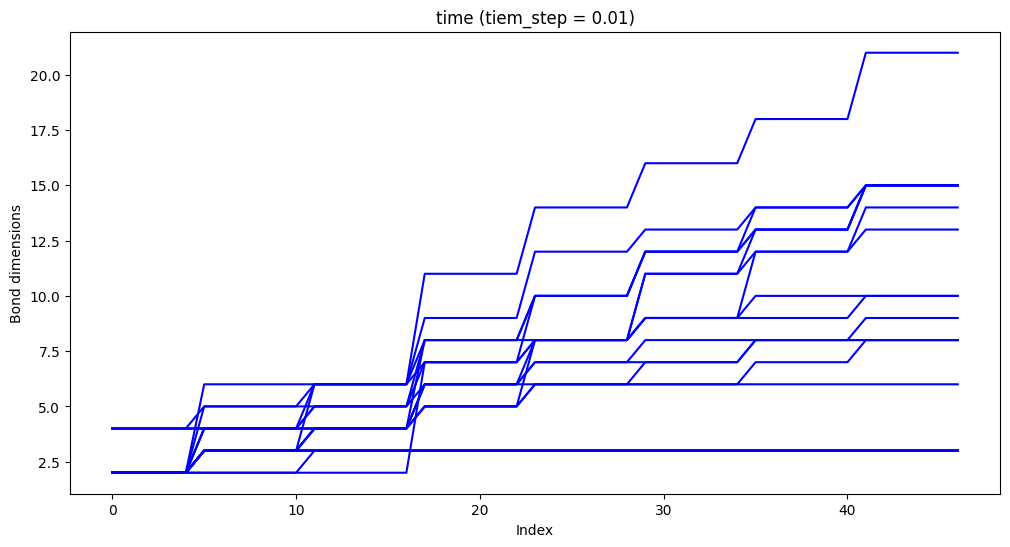

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

for key, values in tdvp_ex1.bond_dims.items():
    x = list(range(len(values)))
    ax.plot(x, values, color='blue')

#blue_patch = plt.Line2D([0], [0], color='blue', label='QR-split form (8 min)')

ax.set_xlabel('Index')
ax.set_ylabel('Bond dimensions')
ax.set_title('time (tiem_step = 0.01)')


plt.show()


In [44]:
times = tdvp_ex1.times()
results_H = tdvp_ex1.operator_results()[0]
results_N = tdvp_ex1.operator_results()[1]
results_Corr = [np.linalg.norm(a) for a in tdvp_ex1.operator_results()[2]]

c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


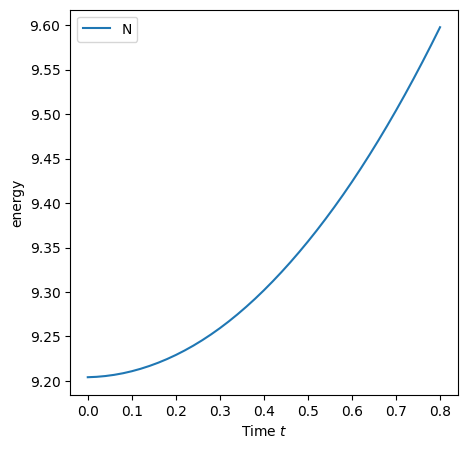

In [45]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(5,5))

axs1.plot(times, results_N , label="N")
#axs1.plot(times, results_H , label="H")
#axs1.plot(times, results_Corr , label="Corr")

axs1.set_xlabel("Time $t$")
axs1.set_ylabel("energy")  
axs1.legend()

In [29]:
zero_indices = np.where(results_N == 0)[0]
zero_indices

array([40], dtype=int64)

In [34]:
H = [-3.47994052+3.00321106e-16j, -3.47955261-2.13703137e-02j,
       -3.47876933-4.27419100e-02j, -3.47855819-6.42359328e-02j,
       -3.47862421-8.55744219e-02j, -3.47788012-1.06926130e-01j,
       -3.47884758-1.28434437e-01j, -3.4798439 -1.50033068e-01j,
       -3.4805605 -1.71619075e-01j, -3.48095265-1.93183019e-01j,
       -3.48100976-2.14726575e-01j, -3.48072746-2.36253191e-01j,
       -3.48010304-2.57766567e-01j, -3.47913442-2.79270360e-01j,
       -3.47781989-3.00768135e-01j, -3.47615795-3.22263379e-01j,
       -3.47414732-3.43759521e-01j, -3.47178685-3.65259947e-01j,
       -3.46907549-3.86768001e-01j, -3.46601232-4.08286984e-01j,
       -3.46259646-4.29820146e-01j, -3.45882712-4.51370693e-01j,
       -3.45470358-4.72941779e-01j, -3.45022514-4.94536506e-01j,
       -3.44539117-5.16157926e-01j, -3.44020104-5.37809040e-01j,
       -3.43465417-5.59492794e-01j, -3.42874999-5.81212081e-01j,
       -3.42248793-6.02969736e-01j, -3.41586742-6.24768540e-01j,
       -3.40888786-6.46611209e-01j, -3.40154864-6.68500403e-01j,
       -3.39384911-6.90438715e-01j, -3.3857886 -7.12428678e-01j,
       -3.37736635-7.34472759e-01j, -3.36858155-7.56573361e-01j,
       -3.35943334-7.78732823e-01j, -3.34992075-8.00953422e-01j,
       -3.34004274-8.23237373e-01j, -3.32979816-8.45586831e-01j,
       -3.31918574-8.68003890e-01j, -3.30820411-8.90490589e-01j,
       -3.29685177-9.13048909e-01j, -3.28512706-9.35680775e-01j,
       -3.2730282 -9.58388059e-01j, -3.26055321-9.81172577e-01j,
       -3.24769997-1.00403609e+00j, -3.23446618-1.02698032e+00j,
       -3.2208493 -1.05000691e+00j, -3.20684663-1.07311748e+00j,
       -3.19245522-1.09631357e+00j]

In [35]:
N = [9.20362043-1.05119483e-16j, 9.20362201-1.23859908e-03j,
       9.20354376-2.47605434e-03j, 9.20332297-3.76212684e-03j,
       9.20289571-5.00648135e-03j, 9.20239407-6.28460759e-03j,
       9.20169729-7.75938578e-03j, 9.20088069-9.17550426e-03j,
       9.19996074-1.05627487e-02j, 9.19894152-1.19312268e-02j,
       9.19782425-1.32862374e-02j, 9.19660934-1.46309292e-02j,
       9.19529696-1.59673567e-02j, 9.19388727-1.72969563e-02j,
       9.19238047-1.86207904e-02j, 9.19077683-1.99396849e-02j,
       9.18907669-2.12543084e-02j, 9.18728045-2.25652169e-02j,
       9.18538857-2.38728804e-02j, 9.18340155-2.51776995e-02j,
       9.18131997-2.64800164e-02j, 9.17914446-2.77801239e-02j,
       9.1768757 -2.90782716e-02j, 9.17451445-3.03746710e-02j,
       9.17206152-3.16694989e-02j, 9.16951776-3.29629004e-02j,
       9.16688409-3.42549909e-02j, 9.16416151-3.55458572e-02j,
       9.16135105-3.68355596e-02j, 9.15845382-3.81241321e-02j,
       9.15547098-3.94115834e-02j, 9.15240378-4.06978979e-02j,
       9.14925351-4.19830364e-02j, 9.14602156-4.32669368e-02j,
       9.14270938-4.45495150e-02j, 9.1393185 -4.58306663e-02j,
       9.13585055-4.71102664e-02j, 9.13230723-4.83881733e-02j,
       9.12869036-4.96642289e-02j, 9.12500185-5.09382613e-02j,
       9.12124371-5.22100874e-02j, 9.11741808-5.34795159e-02j,
       9.1135272 -5.47463507e-02j, 9.10957347-5.60103949e-02j,
       9.1055594 -5.72714552e-02j, 9.10148764-5.85293474e-02j,
       9.09736102-5.97839015e-02j, 9.09318251-6.10349686e-02j,
       9.08895526-6.22824280e-02j, 9.08468257-6.35261952e-02j,
       9.08036797-6.47662306e-02j]

In [36]:
Corr = [0.15118553008831065,
 0.15224006992760974,
 0.1532982011183182,
 0.15436090971358404,
 0.1554078147526842,
 0.15644671430058826,
 0.15734391736343026,
 0.15823684601173527,
 0.15913655491938553,
 0.16004218167068582,
 0.1609529154944039,
 0.16186829621757687,
 0.16278807550693716,
 0.1637121205923159,
 0.16464036113518804,
 0.16557275949525863,
 0.16650929281387047,
 0.16744994159186172,
 0.16839468239218722,
 0.169343483319073,
 0.17029630127440382,
 0.1712530803125978,
 0.17221375065618016,
 0.17317822813209846,
 0.17414641387282992,
 0.17511819419798824,
 0.17609344060644672,
 0.17707200984155347,
 0.1780537439893081,
 0.17903847058384842,
 0.18002600269792576,
 0.18101613899472008,
 0.18200866373002067,
 0.1830033466892396,
 0.183999943057053,
 0.1849981931925494,
 0.18599782233202,
 0.18699854018807222,
 0.18800004047622046,
 0.1890020003355155,
 0.19000407966939512,
 0.19100592039491052,
 0.19200714561464177,
 0.19300735869722477,
 0.1940061422908298,
 0.1950030572384138,
 0.195997641445106,
 0.1969894086558976,
 0.19797784718570763,
 0.19896241856811217,
 0.19994255616807266]

In [35]:
y = np.array([ 9.20362043e+00,  9.20384041e+00,  9.20451788e+00,  9.20564724e+00,
        9.20722923e+00,  9.20926502e+00,  9.21175617e+00,  9.21470464e+00,
        9.21811279e+00,  9.22198340e+00,  9.22631965e+00,  9.23112513e+00,
        9.23640382e+00,  9.24216016e+00,  9.24839896e+00,  9.25512550e+00,
        9.26234546e+00,  9.27006496e+00,  9.27829057e+00,  9.28702930e+00,
        9.29628862e+00,  9.30607647e+00,  9.31640127e+00,  9.32727190e+00,
        9.33869777e+00,  9.35068878e+00,  9.36325536e+00,  9.37640848e+00,
        9.39015969e+00,  9.40452107e+00,  9.41950533e+00,  9.43512580e+00,
        9.45139644e+00,  9.46833189e+00,  9.48594750e+00,  9.50425936e+00,
        9.52328431e+00,  9.54304005e+00,  9.56354512e+00,  9.58481899e+00,
        9.60700177e+00,  9.63038732e+00,  9.65469798e+00,  9.67993603e+00,
        9.70612534e+00,  9.73329489e+00,  9.76147662e+00,  9.79070497e+00,
        9.82101678e+00,  9.85245140e+00,  9.88505080e+00,  9.91885980e+00,
        9.95392624e+00,  9.99030131e+00,  1.00280397e+01,  1.00672002e+01,
        1.01078455e+01,  1.01500433e+01,  1.01938660e+01,  1.02393918e+01,
        1.02851609e+01,  1.03323550e+01,  1.03818831e+01,  1.04334291e+01,
        1.04869786e+01,  1.05425787e+01,  1.06002948e+01,  1.06602011e+01,
        1.07223792e+01,  1.07869181e+01,  1.08539145e+01,  1.09234743e+01,
        1.09957120e+01,  1.10707508e+01,  1.11487223e+01,  1.12297649e+01,
        1.13140220e+01,  1.14016393e+01,  1.14927616e+01,  1.15875269e+01,
        1.16891405e+01,  1.17944682e+01,  1.19046714e+01,  1.20202081e+01,
        1.21414390e+01,  1.22686515e+01,  1.24020602e+01,  1.25417696e+01,
        1.26877099e+01,  1.28395428e+01,  1.29965278e+01,  1.31573365e+01,
        1.33198028e+01,  1.34805992e+01,  1.36348392e+01,  1.37756306e+01,
        1.38936477e+01,  1.39768597e+01,  1.40106464e+01,  1.39786084e+01,
        1.38442165e+01,  1.35685058e+01,  1.31839069e+01,  1.26981317e+01,
        1.21284268e+01,  1.14986172e+01,  1.08345438e+01,  1.01596609e+01,
        9.49205840e+00,  8.84335641e+00,  8.21914333e+00,  7.62027037e+00,
        7.04435190e+00,  6.48704942e+00,  5.94295148e+00,  5.40602369e+00,
        4.86969123e+00,  4.32665724e+00,  3.76858749e+00,  3.18582701e+00,
        0.00000000e+00,  2.24109912e+00,  1.54729134e+00,  7.91203340e-01,
       -2.94132512e-02, -9.03166918e-01, -1.79736786e+00, -2.65340270e+00,
       -3.39152088e+00, -3.92938475e+00, -4.20940588e+00, -4.21958675e+00,
       -3.99432258e+00, -3.59653130e+00, -3.09464796e+00, -2.54651138e+00,
       -1.99328210e+00, -1.46034430e+00, -9.61092606e-01, -5.00960306e-01,
       -8.06125206e-02,  3.01864207e-01,  6.49592143e-01,  9.66104130e-01,
        1.25490997e+00,  1.51928190e+00,  1.76216561e+00,  1.98615945e+00,
        2.19352859e+00,  2.38623489e+00,  2.56597221e+00,  2.73420171e+00,
        2.89218460e+00,  3.04101115e+00,  3.18162600e+00,  3.31484965e+00,
        3.44139673e+00,  3.56189136e+00,  3.67687998e+00,  3.78684219e+00,
        3.89219970e+00,  3.99332391e+00,  4.09054222e+00,  4.18414327e+00,
        4.27438146e+00,  4.36148063e+00,  4.44563721e+00,  4.52702294e+00,
        4.60578715e+00,  4.68205871e+00,  4.75594775e+00,  4.82754719e+00,
        4.89693414e+00,  4.96417107e+00,  5.02930707e+00,  5.09237892e+00,
        5.15341222e+00,  5.21242248e+00,  5.26941623e+00,  5.32439223e+00,
        5.37734257e+00,  5.42825403e+00,  5.47710933e+00,  5.52388854e+00,
        5.56857051e+00,  5.61113431e+00,  5.65156083e+00,  5.68983421e+00,
        5.72594336e+00,  5.75988341e+00,  5.79165699e+00,  5.82127543e+00,
        5.84875967e+00,  5.87414105e+00,  5.89746162e+00,  5.91877428e+00,
        5.93814251e+00,  5.95563969e+00,  5.97134819e+00,  5.98535807e+00,
        5.99776553e+00,  6.00867119e+00,  6.01817829e+00,  6.02639077e+00,
        6.03341150e+00,  6.03934064e+00,  6.04427414e+00,  6.04830258e+00,
        6.05151028e+00,  6.05397469e+00,  6.05576621e+00,  6.05694811e+00,
        6.05757695e+00,  6.05770302e+00,  6.05737109e+00,  6.05662121e+00,
        6.05548967e+00,  6.05400986e+00,  6.05221330e+00,  6.05013044e+00,
        6.04779153e+00,  6.04522735e+00,  6.04246979e+00,  6.03955241e+00,
        6.03651080e+00,  6.03338290e+00,  6.03020915e+00,  6.02703260e+00,
        6.02389890e+00,  6.02085626e+00,  6.01795531e+00,  6.01524892e+00,
        6.01279207e+00,  6.01064156e+00,  6.00885585e+00,  6.00749482e+00,
        6.00661957e+00,  6.00629221e+00,  6.00657575e+00,  6.00753385e+00,
        6.00923079e+00,  6.01173132e+00,  6.01510061e+00,  6.01940415e+00,
        6.02470781e+00,  6.03107774e+00,  6.03858042e+00,  6.04728273e+00,
        6.05725193e+00,  6.06855573e+00,  6.08126242e+00,  6.09544089e+00,
        6.11116074e+00,  6.12849242e+00,  6.14750724e+00,  6.16827757e+00,
        6.19087685e+00,  6.21537975e+00,  6.24186216e+00,  6.27040130e+00,
        6.30107569e+00,  6.33396513e+00,  6.36915058e+00,  6.40671400e+00,
        6.44673807e+00,  6.48930573e+00,  6.53449966e+00,  6.58240143e+00,
        6.63309044e+00,  6.68664253e+00,  6.74312815e+00,  6.80261001e+00,
        6.86514014e+00,  6.93075616e+00,  6.99947669e+00,  7.07129569e+00,
        7.14617575e+00,  7.22404000e+00,  7.30476288e+00,  7.38815956e+00,
        7.47397454e+00,  7.56186963e+00,  7.65141208e+00,  7.74206404e+00,
        7.83317450e+00,  7.92397548e+00,  8.01358425e+00,  8.10101339e+00,
        8.18518988e+00,  8.26498392e+00,  8.33924681e+00,  8.40685585e+00,
        8.46676269e+00,  8.51804060e+00,  8.55992541e+00,  8.59184526e+00,
        8.61343592e+00,  8.62453975e+00,  8.62518937e+00,  8.61557848e+00,
        8.59602415e+00,  8.56692528e+00,  8.52872183e+00,  8.48185846e+00,
        8.42675510e+00,  8.36378581e+00,  8.29326614e+00,  8.21544826e+00,
        8.13052301e+00,  8.03862731e+00,  7.93985567e+00,  7.83427449e+00,
        7.72193797e+00,  7.60290454e+00,  7.47725313e+00,  7.34509825e+00,
        7.20660350e+00,  7.06199272e+00,  6.91155852e+00,  6.75566757e+00,
        6.59476273e+00,  6.42936153e+00,  6.26005139e+00,  6.08748162e+00,
        5.91235251e+00,  5.73540228e+00,  5.55739223e+00,  5.37909110e+00,
        5.20125913e+00,  5.02463276e+00,  4.84991053e+00,  4.67774068e+00,
        4.50871098e+00,  4.34334092e+00,  4.18207649e+00,  4.02528737e+00,
        3.87326643e+00,  3.72623138e+00,  3.58432805e+00,  3.44763509e+00,
        3.31616977e+00,  3.18989437e+00,  3.06872297e+00,  2.95252842e+00,
        2.84114910e+00,  2.73439540e+00,  2.63205586e+00,  2.53390271e+00,
        2.43969690e+00,  2.34919256e+00,  2.26214088e+00,  2.17829342e+00,
        2.09740496e+00,  2.01923585e+00,  1.94355391e+00,  1.87013603e+00,
        1.79876939e+00,  1.72925244e+00,  1.66139563e+00,  1.59502194e+00,
        1.52996730e+00,  1.46608084e+00,  1.40322509e+00,  1.34127607e+00,
        1.28012335e+00,  1.21967011e+00,  1.15983315e+00,  1.10054293e+00,
        1.04174363e+00,  9.83393282e-01,  9.25463934e-01,  8.67941973e-01,
        8.10828579e-01,  7.54140407e-01,  6.97910599e-01,  6.42190235e-01,
        5.87050437e-01,  5.32585391e-01,  4.78916710e-01,  4.26199728e-01,
        3.74632655e-01,  3.24469956e-01,  2.76042132e-01,  2.29785252e-01,
        1.86285731e-01,  1.46349314e-01,  1.11109540e-01,  8.22022560e-02,
        6.20541742e-02,  5.43754180e-02,  6.50321800e-02,  1.03662254e-01,
        1.86825924e-01,  3.44548116e-01,  6.34973894e-01,  1.18041034e+00,
        2.26678156e+00,  4.65862823e+00,  1.07335319e+01,  2.77226006e+01,
        4.92247321e+01])

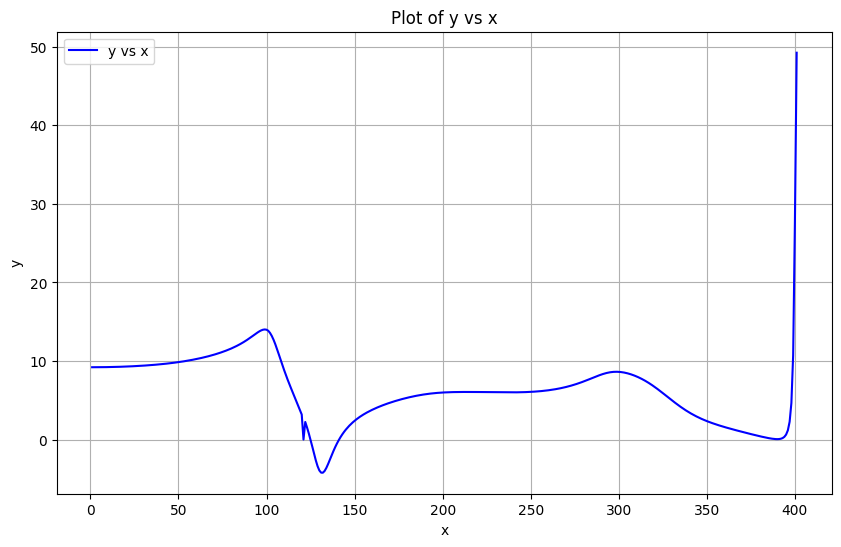

In [37]:
import matplotlib.pyplot as plt

x = np.arange(1, len(y) + 1)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='y vs x', color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of y vs x')
plt.legend()
plt.grid(True)
plt.show()